# Graph Clustering and Spectral Detectability Threshold


Spectral methods are often used for tasks such as graph clustering, usually working with the adjacency matrix $A$ or some version of the graph Laplacian $L$. One appealing reason to use such methods is their sound mathematical foundations. However, in practical applications over real or realistic graphs, spectral methods typically perform worse than other methods, except for special cases like stochastic block models with two communities.

I recently came across a paper called spectral redemption https://www.pnas.org/doi/full/10.1073/pnas.1312486110
which claims to obtain better results with spectral methods for clustering sparse graphs. The novelty is to work with a different object, namely the $2m \times 2m$ matrix $B$, where $m$ is the number of edges in the graph (direction is considered) and $B((u,v),(w,x))=1$ iff $v=w$ and $u \ne x$. Thus this is some kind of non-backtracking operator. Unfortunately, the only link to (Matlab) code implementing their approach is not longer valid, so I could not test it easily. However, the paper has a nice review of spectral detectability threshold which I used in a quick re-visit of comparison study between graph clustering algorithms.


## Spectral detectability threshold

We suppose graph $G$ is generated via a stochastic block model (SBM); in such a model, there are $q$ clusters, and the probability of an edge between nodes respectively in cluster $u$ and $v$ is $p(u,v)$. In its simplest form which we use here, the $n$ nodes are distributed randomly between the clusters, and $p(u,v) = p(in)$ if $u=v$ while $p(u,v)=p(out)$ if $u \ne v$, with $p(in)>p(out)$.

We define $c(in)=n \times p(in)$ and $c(out)=n \times p(out)$ and let $c$ be the average degree. 

In the case $q=2$, the detectability threshold states that, in the limit for large $n$ but with $c(in)$ and $c(out)$ constant, if $c(in)-c(out) <= 2*\sqrt{c}$, then no algorithm can label the vertices better than chance. 

In the case $q>2$, the threshold is $c(in)-c(out) <= q*\sqrt{c}$ but in this case, the threshold is to be interpreted as a boundary between “feasible” and “hard to cluster” regions.


## Graph clustering on SBM Graphs

I tested this threshold for various graph clustering algorithms, including the recently proposed Leiden algorithm, which is a variation of the Louvain algorithm. I also compared with ECG, Leading Eigenvector, Infomap and Label Propagation. In previous studies of this sort, I had mainly used LFR or ABCD benchmark graphs, so I was also curious to see the results on SBM.

Moreover, I recently updated ECG on GitHub and PyPI to add an option so that Leiden can be used for the final clustering, so I also tested this option, as well as running personalised Pagerank (PPR) to initialize edge weights, then running Leiden.


For this experiment, we generated 1,075 graphs with the following parameters: $n$=5,000 nodes, c(in)=250, 5<=c(out)<=215 and 2<=q<=50. 

In [1]:
import igraph as ig
import numpy as np
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
import matplotlib.pyplot as plt
import seaborn as sms
import pickle


In [2]:
## fix the SBM parameters
n_nodes = 5000
n_communities = np.arange(2,51,2) ## values for 'q'
c_in = 250 
p_in = c_in / n_nodes

print('p_in =',p_in)
step = 5
C_out = np.arange(step,216,step)

print('min p_out=',C_out[0]/n_nodes)
print('max p_out=',C_out[-1]/n_nodes)

## spectral detectability threshold -- exact with 2 communities, indicative for 3+
spectral_th = []
for q in n_communities:
    spectral_th.append( ((2*c_in+q*(q-1)) - q*np.sqrt(4*c_in+(q-1)**2) )/2)
spectral_th = [max(0,i) for i in spectral_th]

## algorithms
algos = ['LeadEigen','Louvain','Infomap','ECG','Leiden','LabelProp']


p_in = 0.05
min p_out= 0.001
max p_out= 0.043


In [3]:
%%time
## Uncomment to re-run
dim1 = len(C_out)
dim2 = len(n_communities)
M_ARI = np.zeros((len(algos),dim1,dim2))
M_AMI = np.zeros((len(algos),dim1,dim2))

def le(g):
    try:
        cm = g.community_leading_eigenvector().membership
    except:
        cm = np.repeat(0,g.vcount())
    return cm
    

for i in range(dim1):
    c_out = C_out[i] 
    print('c_out = ',c_out)
    
    for j in range(dim2):

        # number of communities, nodes, p(in), p(out)
        comm = n_communities[j]
        n = n_nodes
        p_out = c_out / n 
            
        ## Planted partition model
        td = [1/comm]*comm
        P = np.full((comm,comm),p_out)
        np.fill_diagonal(P,p_in)
        g = ig.Graph.Preference(n=n,type_dist=td,pref_matrix=P.tolist(),attribute='class')
        
        ## clustering algorithms
        F = [le(g),
             g.community_multilevel().membership,
             g.community_infomap().membership,
             g.community_ecg(ens_size=32, final='leiden').membership,
             g.community_leiden('modularity').membership,
             g.community_label_propagation().membership]
        ctr = 0 
        for f in F:
            cm = f
            M_ARI[ctr,i,j] = ARI(cm,g.vs['class'])
            M_AMI[ctr,i,j] = AMI(cm,g.vs['class'])
            ctr += 1


c_out =  5


/Users/francois/anaconda3/envs/graphmining/lib/python3.10/site-packages/igraph/community.py:132: RuntimeWarning: ARPACK solver failed to converge (10001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:893
  membership, _, q = GraphBase.community_leading_eigenvector(graph, clusters, **kwds)
/Users/francois/anaconda3/envs/graphmining/lib/python3.10/site-packages/igraph/community.py:132: RuntimeWarning: ARPACK solver failed to converge (10001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:893
  membership, _, q = GraphBase.community_leading_eigenvector(graph, clusters, **kwds)


c_out =  10
c_out =  15
c_out =  20
c_out =  25
c_out =  30
c_out =  35
c_out =  40
c_out =  45
c_out =  50
c_out =  55
c_out =  60
c_out =  65
c_out =  70
c_out =  75
c_out =  80
c_out =  85
c_out =  90
c_out =  95
c_out =  100
c_out =  105
c_out =  110
c_out =  115
c_out =  120
c_out =  125
c_out =  130
c_out =  135
c_out =  140
c_out =  145
c_out =  150
c_out =  155
c_out =  160
c_out =  165
c_out =  170
c_out =  175
c_out =  180
c_out =  185
c_out =  190
c_out =  195
c_out =  200
c_out =  205
c_out =  210
c_out =  215
CPU times: user 11h 5min 9s, sys: 3min, total: 11h 8min 9s
Wall time: 11h 57min 12s


In [17]:
pickle.dump((M_ARI,M_AMI),open("SBM_5000.pkl","wb"))


In [21]:
43*25

1075

Results (AMI: Adjusted Mutual Information, ARI: Adjusted RAND Index and AGRI: Adjusted Graph-aware RAND Index) are shown below. The white curve is the spectral detectability threshold.

There are a few interesting observations from those results:

* Leading Eigenvectors, a spectral method, performs well for small $q$ (fair to good results above the threshold), but not so well as $q$ increases (we see more and more ‘black’ above the white threshold curve).
* Label Propagation and Infomap perform well only when $c(out)$ is small which in other words amounts to say that the “noise level” is not too high. This is something we had already noticed with LFR and ABCD graphs, in particular with Label Propagation.
* Leiden provides a slight improvement over Louvain and both perform well above the detectability threshold, albeit with some gap. Seeding Leiden with PPR edge weights provides some improvement.
* The (pleasant) surprise is how both flavours of ECG remains very close to the spectral detectability threshold in terms of performance for all values of $q$.


In [4]:
#M_ARI, M_AGRI, M_AMI = pickle.load(open("SBM_2500.pkl","rb"))

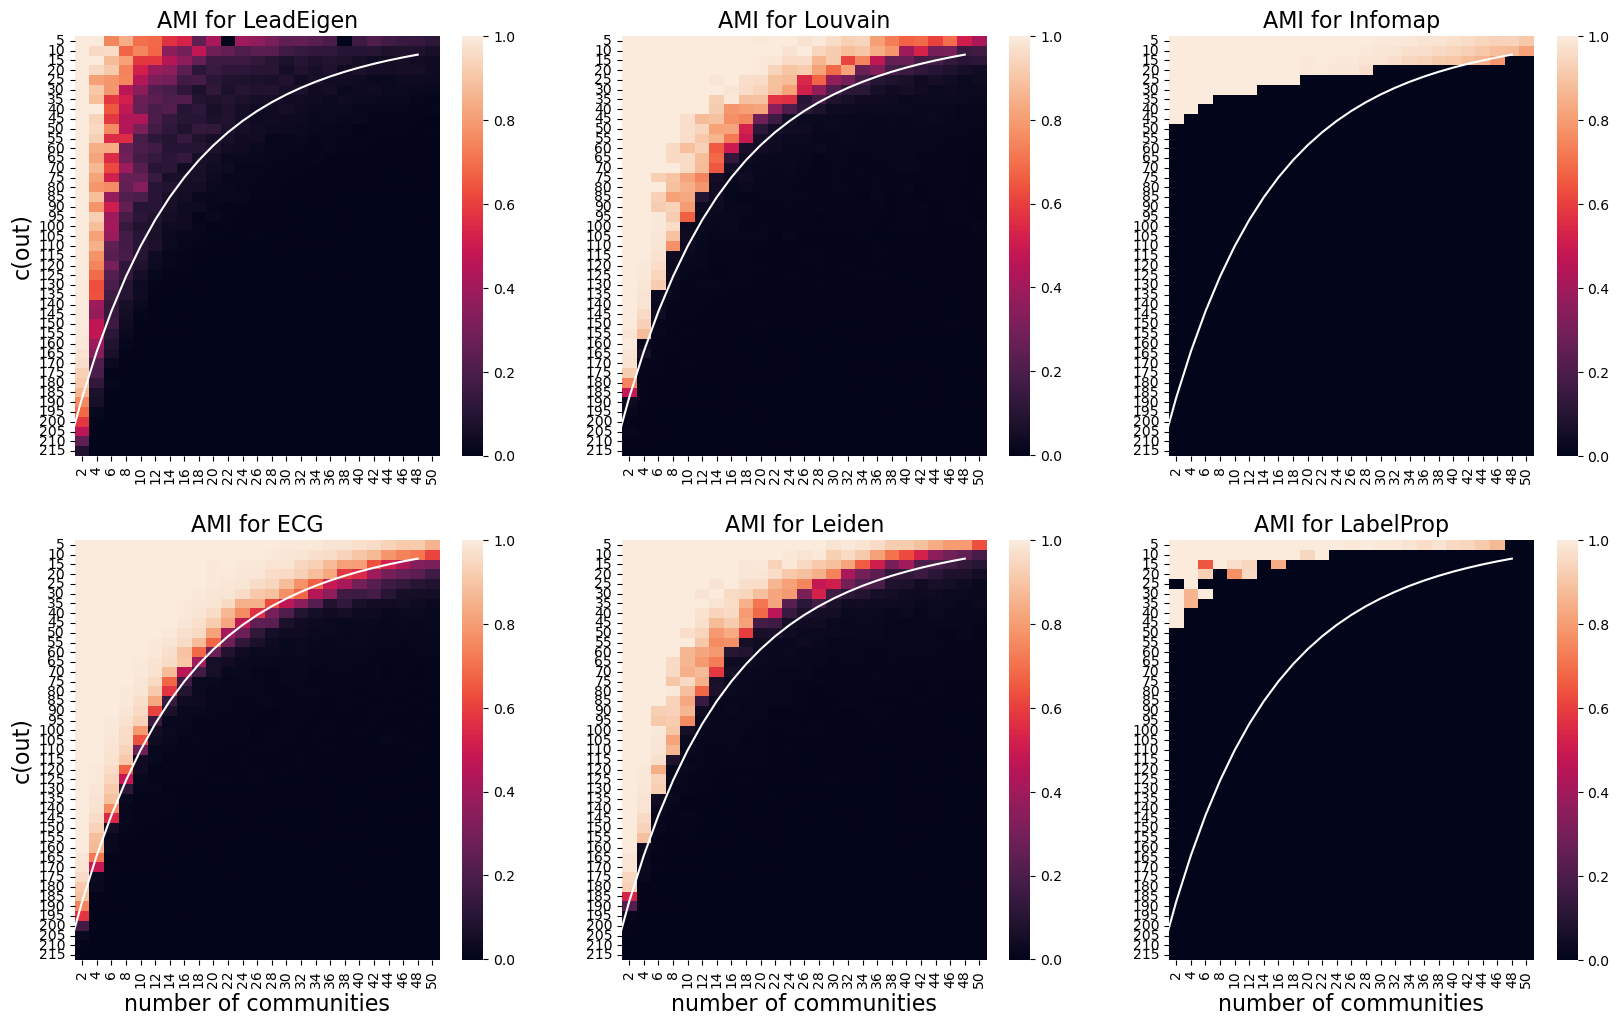

In [14]:
plt.figure(figsize=(20,12))
step = 5
for k in range(6):
    plt.subplot(2,3,k+1)
    sms.heatmap(M_AMI[k], xticklabels=n_communities, yticklabels=C_out)
    sms.lineplot(x=[i/2-1.5 for i in n_communities],y=[i/5-1.5 for i in spectral_th],color='white')
    plt.title('AMI for '+algos[k], fontsize=16)
    if k%3 == 0:
        plt.ylabel('c(out)', fontsize=16);
    if k>=3:
        plt.xlabel('number of communities', fontsize=16);


In the plot below, we show the **average rank** for each algorithm grouping by the number of communities. We only consider the cases that are above the detectability threshold.


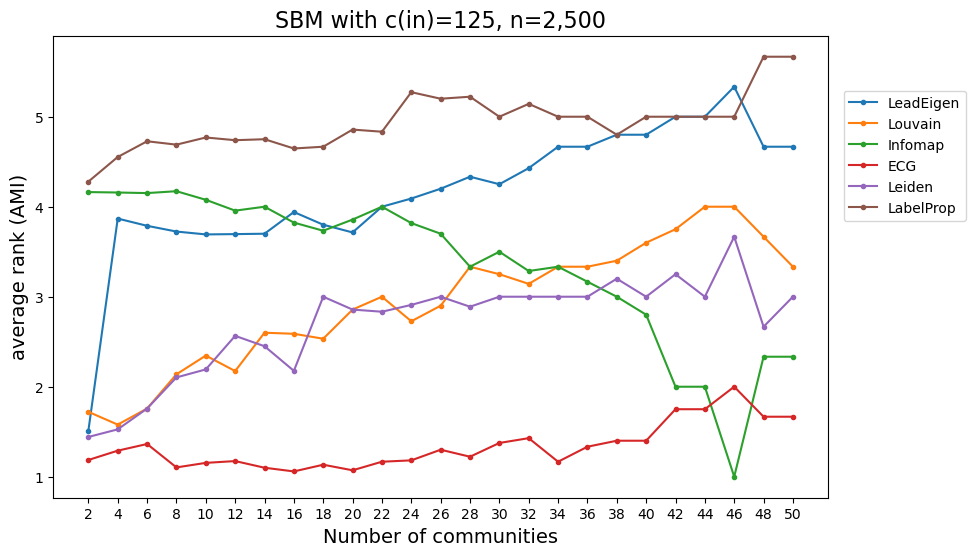

In [16]:
from scipy.stats import rankdata
R = []
for i in range(dim2): ##COMM
    r = np.zeros((6))
    s = 0
    for j in range(dim1): ##COUT
        if C_out[j] < spectral_th[i]:
            r += rankdata(1-M_AMI[:,j,i],method='min')
            s += 1
    R.append(r/s)
R = np.array(R).transpose()

plt.figure(figsize=(10,6))
for i in range(R.shape[0]):
    plt.plot(n_communities,R[i], '.-',label=algos[i]);
plt.legend(loc=(1.02,.6))
plt.title('SBM with c(in)=125, n=2,500', fontsize=16)
plt.xlabel('Number of communities', fontsize=14)
plt.xticks(n_communities)
plt.ylabel('average rank (AMI)', fontsize=14);
